In [114]:
import re
import pandas as pd
import string
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.util import normalize

from pythainlp.ulmfit import document_vector
from fastai import *
from fastai.text import *
from fastai.basics import *

pd.set_option('display.max_colwidth', 200)
pythainlp.__version__

'2.3.1'

In [115]:
bangrak_df = pd.read_csv('./dist/bangrak.csv')
beauty_df = pd.read_csv('./dist/beauty.csv')
rajdumnern_df = pd.read_csv('./dist/rajdumnern.csv')
religious_df = pd.read_csv('./dist/religious.csv')
sinthorn_df = pd.read_csv('./dist/sinthorn.csv')

In [116]:
df = pd.concat([bangrak_df, beauty_df, rajdumnern_df, religious_df, sinthorn_df])

#df = rajdumnern_df

df.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                  title  \
0                                                        หาเพื่อนคุยค่ะ   
1                                                 เราควรรู้สึกยังไงดี ?   
2             LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที?   
3                                                          รักข้างเดียว   
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิง(ยิ่งกว่าอีกมั้ง)   

                                                                                                                         tags  \
0                                                               ['ศาลาคนโสด', 'หาเพื่อน', 'ศาลาคนเศร้า', 'ประสบการณ์ความรัก']   
1                                                                                                       ['ประสบการณ์ความรัก']   
2  ['ความรักต่างวัย', 'ความรักวัยรุ่น', 'ความรักเพศที่สาม', 'กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT)', 'ความหลากหลายทางเพศ']   
3                                                                                                ['ความรักวัยรุ่น', 'แอบรัก']   
4                                                                                                          ['ความรักวัยรุ่น']   

                                link  \
0  https://pantip.com/topic/40753182   
1  https://pantip.com/topic/40753170   
2  https://pantip.com/topic/40753159   
3  https://pantip.com/topic/40753153   
4  https://pantip.com/topic/40753147   

                                                                                                                                                                                                    detail  
0                                                                                                                                                                              \n   แก้ไขข้อความเมื่อ   \n  
1  \r\n\t\t\t\t\t\t\t\tแฟนเราชอบไปส่องผู้หญิง ไปเพิ่มเพื่อนผู้หญิงบ่อยมาก\nทั้งIG Facebook ชอบกดไลค์ กดอิโมจิ \nเวลาไปดูรายการที่มีเปิดวาร์ป ถ้าหญิงสวยก็จะไปส่องไปเพิ่มเพื่อนตลอด แฟนใครเป็นมั่งคะ แล้...  
2  \r\n\t\t\t\t\t\t\t\tพูดถึงสังคมในไทย \n-สาวประเภทสองเยอะมากและสวยมาก\n-เกย์ ไบ รสนิยมต่างๆก็เยอะมาก ออกสื่อก็เยอะ\n-ซีรี่วาย หนังวาย เลสเบี้ยน ออกสื่อโชเชี่ยว\n-มีการแต่งงานกันในเพศเดียวกัน\n-อื่น...  
3  \r\n\t\t\t\t\t\t\t\tเรามีแอบชอบพี่คนนึงเค้าโตกว่าเรา2ปี เรื่องของเราอาจเหมือนนิยายนะ แต่มันคือเรื่องจริง เริ่มจาก\nเราเริ่มชอบเค้าตอนม.1 ตอนนั้นเป็นค่าย เค้ามีให้เล่นเกม เราตกหลุมรักเพราะตอนเราจะล...  
4  \r\n\t\t\t\t\t\t\t\tตามกระทู้ ใครมีแฟนแบบนี้หรือมีโมเม้นต์อย่างนี้บ้าง\nใครที่ชอบให้แฟนสาวง้อ(ตัวเองผิดไม่เป็น)  ใครที่ต้องง้อแฟนชายบ่อยๆ\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t

In [117]:
df.shape

(25795, 5)

In [118]:
def cleaner(text):
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"[^\u0E00-\u0E7Fa-zA-Z ]", "", text)
  text = re.sub(r"\n|\r|\t", " ", text)
  text = text.translate(str.maketrans("", "", string.punctuation))
  return text

In [119]:
df['clean_detail'] = df['detail'].apply(cleaner)
df['clean_title'] = df['title'].apply(cleaner)
df.head()

Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                  title  \
0                                                        หาเพื่อนคุยค่ะ   
1                                                 เราควรรู้สึกยังไงดี ?   
2             LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที?   
3                                                          รักข้างเดียว   
4  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิง(ยิ่งกว่าอีกมั้ง)   

                                                                                                                         tags  \
0                                                               ['ศาลาคนโสด', 'หาเพื่อน', 'ศาลาคนเศร้า', 'ประสบการณ์ความรัก']   
1                                                                                                       ['ประสบการณ์ความรัก']   
2  ['ความรักต่างวัย', 'ความรักวัยรุ่น', 'ความรักเพศที่สาม', 'กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT)', 'ความหลากหลายทางเพศ']   
3                                                                                                ['ความรักวัยรุ่น', 'แอบรัก']   
4                                                                                                          ['ความรักวัยรุ่น']   

                                link  \
0  https://pantip.com/topic/40753182   
1  https://pantip.com/topic/40753170   
2  https://pantip.com/topic/40753159   
3  https://pantip.com/topic/40753153   
4  https://pantip.com/topic/40753147   

                                                                                                                                                                                                    detail  \
0                                                                                                                                                                              \n   แก้ไขข้อความเมื่อ   \n   
1  \r\n\t\t\t\t\t\t\t\tแฟนเราชอบไปส่องผู้หญิง ไปเพิ่มเพื่อนผู้หญิงบ่อยมาก\nทั้งIG Facebook ชอบกดไลค์ กดอิโมจิ \nเวลาไปดูรายการที่มีเปิดวาร์ป ถ้าหญิงสวยก็จะไปส่องไปเพิ่มเพื่อนตลอด แฟนใครเป็นมั่งคะ แล้...   
2  \r\n\t\t\t\t\t\t\t\tพูดถึงสังคมในไทย \n-สาวประเภทสองเยอะมากและสวยมาก\n-เกย์ ไบ รสนิยมต่างๆก็เยอะมาก ออกสื่อก็เยอะ\n-ซีรี่วาย หนังวาย เลสเบี้ยน ออกสื่อโชเชี่ยว\n-มีการแต่งงานกันในเพศเดียวกัน\n-อื่น...   
3  \r\n\t\t\t\t\t\t\t\tเรามีแอบชอบพี่คนนึงเค้าโตกว่าเรา2ปี เรื่องของเราอาจเหมือนนิยายนะ แต่มันคือเรื่องจริง เริ่มจาก\nเราเริ่มชอบเค้าตอนม.1 ตอนนั้นเป็นค่าย เค้ามีให้เล่นเกม เราตกหลุมรักเพราะตอนเราจะล...   
4  \r\n\t\t\t\t\t\t\t\tตามกระทู้ ใครมีแฟนแบบนี้หรือมีโมเม้นต์อย่างนี้บ้าง\nใครที่ชอบให้แฟนสาวง้อ(ตัวเองผิดไม่เป็น)  ใครที่ต้องง้อแฟนชายบ่อยๆ\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t   

                                                                                                                                                                                              clean_detail  \
0                                                                                                                                                                                     แก้ไขข้อความเมื่อ      
1  แฟนเราชอบไปส่องผู้หญิง ไปเพิ่มเพื่อนผู้หญิงบ่อยมากทั้งIG Facebook ชอบกดไลค์ กดอิโมจิ เวลาไปดูรายการที่มีเปิดวาร์ป ถ้าหญิงสวยก็จะไปส่องไปเพิ่มเพื่อนตลอด แฟนใครเป็นมั่งคะ แล้วรับมือกับคนแบบนี้ยังไง ...   
2  พูดถึงสังคมในไทย สาวประเภทสองเยอะมากและสวยมากเกย์ ไบ รสนิยมต่างๆก็เยอะมาก ออกสื่อก็เยอะซีรี่วาย หนังวาย เลสเบี้ยน ออกสื่อโชเชี่ยวมีการแต่งงานกันในเพศเดียวกันอื่นอีกมากมายก่ายกองแต่ ทำไมสังคมไทยถึง...   
3  เรามีแอบชอบพี่คนนึงเค้าโตกว่าเราปี เรื่องของเราอาจเหมือนนิยายนะ แต่มันคือเรื่องจริง เริ่มจากเราเริ่มชอบเค้าตอนม ตอนนั้นเป็นค่าย เค้ามีให้เล่นเกม เราตกหลุมรักเพราะตอนเราจะล้มพี่เค้ามารับเราไว้ จากน...   
4                                                                                         ตามกระทู้ ใครมีแฟนแบบนี้หรือมีโมเม้นต์อย่างนี้บ้างใครที่ชอบให้แฟนสาวง้อตัวเอ

In [120]:
df.drop(df['clean_detail'] == "แก้ไขข้อความเมื่อ", errors="ignore")

Unnamed: 0  \
1              1   
2              2   
3              3   
4              4   
5              5   
...          ...   
5143        5143   
5144        5144   
5145        5145   
5146        5146   
5147        5147   

                                                                                                           title  \
1                                                                                          เราควรรู้สึกยังไงดี ?   
2                                                      LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที?   
3                                                                                                   รักข้างเดียว   
4                                           ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิง(ยิ่งกว่าอีกมั้ง)   
5                                                                       ทำไมเวลาทะเลาะกับแฟน แฟนชอบคุยกับคนอื่น?   
...                                                                                                          ...   
5143                                                                          ราคายางพารา กลับขึ้นมาแล้วนะรู้ยัง   
5144           SET ต่อไปจะไม่ใช่กองและหรั่งเป็นฝ่ายคุมตลาด แต่รายย่อยจะคุมแทนเพราะดอกเบี้ยแบงค์ตํ่าเตี้ยเรี่ยดิน   
5145  หุ้นส่งออกไม้ ราคาไม้ คือ คอมโมนิดี้ที่แรงที่สุดในรอบเดือน และทำจุดสูงสุดตลอดกาลในรอบ 41 ปี เร็วแรงติดจรวด   
5146                                                      กู้สินเชื่อบ้าน ปกติกระบวนการเป็นยังไงคะ รอผลนานกี่วัน   
5147                                                     **เพิ่งหัดเทรด** ดีใจจังเลยครับ ได้หุ้นฟรี TRT (13/100)   

                                                                                                                            tags  \
1                                                                                                          ['ประสบการณ์ความรัก']   
2     ['ความรักต่างวัย', 'ความรักวัยรุ่น', 'ความรักเพศที่สาม', 'กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT)', 'ความหลากหลายทางเพศ']   
3                                                                                                   ['ความรักวัยรุ่น', 'แอบรัก']   
4                                                                                                             ['ความรักวัยรุ่น']   
5                                                                                                               ['ปัญหาความรัก']   
...                                                                                                                          ...   
5143                                                                                                                    ['หุ้น']   
5144                              ['หุ้น', 'บริษัทหลักทรัพย์', 'ตลาดหลักทรัพย์', 'กองทุนรวม', 'TFEX (Thailand Future Exchange)']   
5145                                                                                                                ['การลงทุน']   
5146                                                                       ['สินเชื่อเพื่อที่อยู่อาศัย', 'ธนาคาร', 'บ้านเดี่ยว']   
5147              ['ตลาดหลักทรัพย์', 'หุ้น', 'การลงทุน', 'ตลาดหลักทรัพย์ เอ็ม เอ ไอ (MAI)', 'ตลาดหลักทรัพย์แห่งประเทศไทย (SET)']   

                                   link  \
1     https://pantip.com/topic/40753170   
2     https://pantip.com/topic/40753159   
3     https://pantip.com/topic/40753153   
4     https://pantip.com/topic/40753147   
5     https://pantip.com/topic/40753141   
...                                 ...   
5143  https://pantip.com/topic/40689021   
5144  https://pantip.com/topic/40689013   
5145  https://pantip.com/topic/40689010   
5146  https://pantip.com/topic/40689000   
5147  https://pantip.com/topic/40688993   

                                                                                                                                                                                                       detail  \
1     \r\n\t\t\t\t\t\t\t\tแฟนเราชอบไปส่องผู้หญิง ไปเพิ่มเพื่อ

In [121]:
def tokenize_word(text):
    tokenize_word =  word_tokenize(text, engine='newmm')
    tokenize_word = [w for w in tokenize_word  if w not in thai_stopwords() and w.strip()]
    tokenize_word = list(map(lambda x: normalize(x), tokenize_word))
    return tokenize_word

In [122]:
df['tokenize_word_detail'] = df['clean_detail'].apply(tokenize_word)
df['tokenize_word_title'] = df['clean_title'].apply(tokenize_word)

In [123]:
tokenize_word(df.iloc[0]['title'])

['หา', 'เพื่อน', 'คุย']

In [124]:
df['title_count'] = df['tokenize_word_title'].apply(lambda x: len(x))
df

Unnamed: 0  \
0              0   
1              1   
2              2   
3              3   
4              4   
...          ...   
5143        5143   
5144        5144   
5145        5145   
5146        5146   
5147        5147   

                                                                                                           title  \
0                                                                                                 หาเพื่อนคุยค่ะ   
1                                                                                          เราควรรู้สึกยังไงดี ?   
2                                                      LGBTQ ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที?   
3                                                                                                   รักข้างเดียว   
4                                           ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิง(ยิ่งกว่าอีกมั้ง)   
...                                                                                                          ...   
5143                                                                          ราคายางพารา กลับขึ้นมาแล้วนะรู้ยัง   
5144           SET ต่อไปจะไม่ใช่กองและหรั่งเป็นฝ่ายคุมตลาด แต่รายย่อยจะคุมแทนเพราะดอกเบี้ยแบงค์ตํ่าเตี้ยเรี่ยดิน   
5145  หุ้นส่งออกไม้ ราคาไม้ คือ คอมโมนิดี้ที่แรงที่สุดในรอบเดือน และทำจุดสูงสุดตลอดกาลในรอบ 41 ปี เร็วแรงติดจรวด   
5146                                                      กู้สินเชื่อบ้าน ปกติกระบวนการเป็นยังไงคะ รอผลนานกี่วัน   
5147                                                     **เพิ่งหัดเทรด** ดีใจจังเลยครับ ได้หุ้นฟรี TRT (13/100)   

                                                                                                                            tags  \
0                                                                  ['ศาลาคนโสด', 'หาเพื่อน', 'ศาลาคนเศร้า', 'ประสบการณ์ความรัก']   
1                                                                                                          ['ประสบการณ์ความรัก']   
2     ['ความรักต่างวัย', 'ความรักวัยรุ่น', 'ความรักเพศที่สาม', 'กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT)', 'ความหลากหลายทางเพศ']   
3                                                                                                   ['ความรักวัยรุ่น', 'แอบรัก']   
4                                                                                                             ['ความรักวัยรุ่น']   
...                                                                                                                          ...   
5143                                                                                                                    ['หุ้น']   
5144                              ['หุ้น', 'บริษัทหลักทรัพย์', 'ตลาดหลักทรัพย์', 'กองทุนรวม', 'TFEX (Thailand Future Exchange)']   
5145                                                                                                                ['การลงทุน']   
5146                                                                       ['สินเชื่อเพื่อที่อยู่อาศัย', 'ธนาคาร', 'บ้านเดี่ยว']   
5147              ['ตลาดหลักทรัพย์', 'หุ้น', 'การลงทุน', 'ตลาดหลักทรัพย์ เอ็ม เอ ไอ (MAI)', 'ตลาดหลักทรัพย์แห่งประเทศไทย (SET)']   

                                   link  \
0     https://pantip.com/topic/40753182   
1     https://pantip.com/topic/40753170   
2     https://pantip.com/topic/40753159   
3     https://pantip.com/topic/40753153   
4     https://pantip.com/topic/40753147   
...                                 ...   
5143  https://pantip.com/topic/40689021   
5144  https://pantip.com/topic/40689013   
5145  https://pantip.com/topic/40689010   
5146  https://pantip.com/topic/40689000   
5147  https://pantip.com/topic/40688993   

                                                                                                                                                                                                       detail  \
0                                                            

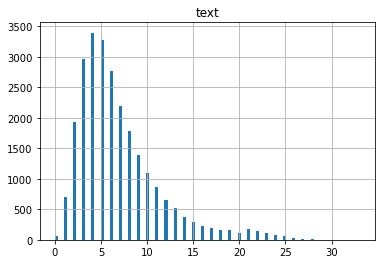

count    25795.000000
mean         6.872533
std          4.585675
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         33.000000
Name: title_count, dtype: float64


In [125]:
#finding a suitable sequence length
# populate the list with length of the questions

length_df = pd.DataFrame({'text': df['title_count']})

length_df.hist(bins=100)
plt.show()
print(df['title_count'].describe())

In [126]:
import ast
df['tags_list'] = df['tags'].apply(lambda x: ast.literal_eval(x))
print(df['tags_list'].head())
print(df.shape)

0                                                               [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                 [ประสบการณ์ความรัก]
2    [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                            [ความรักวัยรุ่น, แอบรัก]
4                                                                                                    [ความรักวัยรุ่น]
Name: tags_list, dtype: object
(25795, 11)


In [127]:
freq= {}
for i in df['tags_list']:
  for j in i:
    if j in freq.keys():
      freq[j] = freq[j] + 1
    else:
      freq[j] = 1

In [128]:
len(freq)

2334

In [129]:
tag_freq = np.array(list(freq.values()))
print(tag_freq.mean())
print(tag_freq.std())


33.53427592116538
175.79246298393008


In [130]:
freq = dict(sorted(freq.items(), key=lambda x:x[1], reverse=True))

In [131]:
freq.items()

, ('ร้านถ่ายรูป', 1), ('presentation งานแต่งงาน', 1), ('ซีรีส์ฝรั่ง', 1), ('สวนสัตว์', 1), ('The Lion King (ภาพยนตร์)', 1), ('ภาพพิมพ์', 1), ('กระดาษพิมพ์ภาพ', 1), ('ฝันรักฝันสลาย (ละคร)', 1), ('อุปกรณ์การเรียน', 1), ('มลพิษจากสารอันตราย', 1), ('รักสุดปลายฟ้า', 1), ('บ้านแฝด', 1), ('3 แซ่บ (รายการโทรทัศน์)', 1), ('ปริญญาเอก', 1), ('Final Fantasy', 1), ('ห้องน้ำสาธารณะ', 1), ('แสงกระสือ (ภาพยนตร์)', 1), ('สาปกระสือ (ละคร)', 1), ('ทาสรัก', 1), ('นักแสดงต่างประเทศ', 1), ('Together With Me อกหักมารักกับผม (ซีรีส์)', 1), ('รู้ไหมใครโสด (รายการโทรทัศน์)', 1), ('รายการการ์ตูน', 1), ('เรียนภาษาที่ต่างประเทศ', 1), ('DARK BLUE KISS จูบสุดท้ายเพื่อนายคนเดียว (ซีรีส์)', 1), ('นักแสดงเกาหลี', 1), ('วีรยา จาง (วี BNK48)', 1), ('คีย์บอร์ด (คอมพิวเตอร์)', 1), ('Playboy', 1), ('นวนิยายรัก', 1), ('ครอบครัวข่าวเด็ก', 1), ('วิงแมน นักรบแห่งความฝัน', 1), ('สองหัวใจ หนึ่งรักเดียว', 1), ('ชูรัก ชูรส', 1), ('โต๊ะจีน', 1), ('การวิเคราะห์งาน (Job Analysis)', 1), ('Tourist Visa', 1), ('JESSI (นักร้องนักดนตรี)', 

In [132]:
list(freq.items())[:200]

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3225),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1842),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 937),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 830),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 534),
 ('ทำผม', 534),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [133]:
common_tags = list(freq.keys())[:200]

In [134]:
common_tags

['ปัญหาความรัก',
 'การเมือง',
 'หุ้น',
 'ศาสนาพุทธ',
 'ประสบการณ์ความรัก',
 'ความงาม',
 'รัฐบาล',
 'ศาสนา',
 'ประสบการณ์ชีวิตคู่',
 'ความรักวัยรุ่น',
 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)',
 'ปฏิบัติธรรม',
 'การลงทุน',
 'Skin Care',
 'ธนาคาร',
 'สิว',
 'พระไตรปิฎก',
 'ความรักวัยทำงาน',
 'การเงิน',
 'ศาลาคนเศร้า',
 'ลดความอ้วน',
 'ข่าวเศรษฐกิจ',
 'คลินิกความงาม',
 'วัด',
 'นักการเมือง',
 'ทำบุญ',
 'ศาลาคนโสด',
 'แอบรัก',
 'ศัลยกรรมความงาม',
 'แฟชั่น',
 'ปัญหาชีวิต',
 'เครื่องสำอาง',
 'ทำผม',
 'ตลาดหลักทรัพย์',
 'ปัญหาวัยรุ่น',
 'พิธีกรรมทางศาสนา',
 'Technical Analysis',
 'สุขภาพกาย',
 'ความรักต่างวัย',
 'มหาสติปัฏฐาน 4',
 'ออกกำลังกาย',
 'บัตรเครดิต',
 'การ์ตูนการเมือง',
 'อาหารเสริม',
 'รัฐศาสตร์',
 'ความเชื่อส่วนบุคคล',
 'ศาสนาอิสลาม',
 'ผลิตภัณฑ์ดูแลเส้นผม',
 'ชีวิตวัยรุ่น',
 'ศาสนาคริสต์',
 'TFEX (Thailand Future Exchange)',
 'กระทรวงสาธารณสุข',
 'พิธีกรรมและความเชื่อ',
 'Value Investment',
 'พรรคเพื่อไทย',
 'การเมืองต่างประเทศ',
 'ปัญหาครอบครัว',
 'ผลิตภัณฑ์ดูแลผิวห

In [135]:
def common_tags_exis(tags_list):
    for tag in tags_list:
        if tag in common_tags:
            return True
    return False

In [136]:
filter_common_df = df[df['tags_list'].apply(common_tags_exis)]
filter_common_df["common_tags"] = filter_common_df['tags_list'].apply(lambda x: list(filter(lambda x: x in common_tags, x)))
print(filter_common_df['common_tags'])
print(filter_common_df.shape)

0                                                                  [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                    [ประสบการณ์ความรัก]
2       [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                               [ความรักวัยรุ่น, แอบรัก]
4                                                                                                       [ความรักวัยรุ่น]
                                                              ...                                                       
5143                                                                                                              [หุ้น]
5144                                [หุ้น, บริษัทหลักทรัพย์, ตลาดหลักทรัพย์, กองทุนรวม, TFEX (Thailand Future Exchange)]
5145                            

In [137]:

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
y = mlb.fit_transform(filter_common_df['common_tags'])
y.shape


(25766, 200)

In [138]:
y[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [139]:
filter_common_df['tags_list'].iloc[0:5]

0                                                               [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                 [ประสบการณ์ความรัก]
2    [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                            [ความรักวัยรุ่น, แอบรัก]
4                                                                                                    [ความรักวัยรุ่น]
Name: tags_list, dtype: object

In [140]:
y[0:5,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 

In [141]:
print(mlb.classes_)

['Cardio' 'Dress Up Club' 'Fundamental Analysis' 'Hurt Room'
 "Men's Fashion" 'Mobile Application' 'SCB EASY' 'Skin Care'
 'TFEX (Thailand Future Exchange)' 'Technical Analysis' 'Value Investment'
 'Weight Training' 'กฎหมายการเมือง' 'กฎหมายชาวบ้าน'
 'กฎหมายอาญา (Criminal Law)' 'กฎแห่งกรรม' 'กระทรวงการคลัง'
 'กระทรวงสาธารณสุข' 'กรุงเทพมหานคร' 'กลอนไทย'
 'กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT)' 'กองทุนรวม' 'การดัดผม'
 'การทำสีผม' 'การยืดผม' 'การลงทุน' 'การวางแผนการเงิน' 'การศึกษา'
 'การออมเงิน' 'การอุปสมบท (การบวชพระภิกษุ)' 'การเงิน' 'การเมือง'
 'การเมืองต่างประเทศ' 'การเมืองท้องถิ่น' 'การเมืองระหว่างประเทศ'
 'การ์ตูนการเมือง' 'ข่าวการเมือง' 'ข่าวต่างประเทศ' 'ข่าวเศรษฐกิจ'
 'คนละครึ่ง (โครงการ)' 'ครอบครัว' 'ครีมกันแดด' 'คลินิกความงาม' 'ความงาม'
 'ความรักต่างวัย' 'ความรักวัยทำงาน' 'ความรักวัยรุ่น' 'ความรักเพศที่สาม'
 'ความหลากหลายทางเพศ' 'ความเชื่อส่วนบุคคล' 'คัมภีร์ไบเบิล'
 'คุ้มครองผู้บริโภค' 'คํานวณแคลอรี่' 'งานขาย' 'จิตวิทยา (Psychology)'
 'ชีวิตวัยรุ่น' 'ตลาดหลักทรัพย์' 'ตลาดหลักทร

In [142]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(filter_common_df['tokenize_word_title'], y, test_size=0.2, random_state=0, shuffle=True)
print(x_tr)
print(y_val)

4712                                                                                    [ตั้งกระทู้, เลือกตั้ง, ประธานาธิบดี, สหรัฐ, แบบนี้]
4346                                                                                    [แชมพู, ทอง, พัน, ช่าง, ผมหงอก, กลับมา, ดำ, รึเปล่า]
178                                                                                                         [สภาพ, จิตใจ, คนไทย, ยุค, โควิด]
3317    [CR, เพลง, รุ่งเรือง, ร่ำรวย, แต่ง, หลวงพ่อ, ช้าง, วัด, จุก, เฌอ, เมือง, แปด, ริ้ว, จังหวะ, สามช่า, ฟัง, สนุก, ข้อคิด, ลอง, ฟัง, ดู]
2007                                                                                                  [มีเงิน, ลุง, ทุน, ธุรกิจ, บาท, ลงทุน]
                                                                        ...                                                                 
2786                                                                  [ข่าว, ดี้, ดี, ปูเค็ม, แซะ, โฆษก, ไทย, อื้อ, ก่น, ก้น, กลายเป็น, ไร่]
4170         

In [143]:
filter_common_df.to_csv("filter_common.csv")

In [144]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

max_len = 10

#tokenize
x_tokenizer = Tokenizer() 
#create vocab
x_tokenizer.fit_on_texts(x_tr)

In [145]:
num_words = len(x_tokenizer.word_index)
num_words

16034

In [146]:
thresh = 3

cnt=0
for key, value in x_tokenizer.word_counts.items():
  if value >= thresh:
    cnt=cnt+1

print(cnt)

6278


In [147]:
import tensorflow as tf
tf.random.set_seed(0)
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import keras.backend as k

In [148]:
x_tokenizer = Tokenizer(num_words=cnt, oov_token='OOV')
x_tokenizer.fit_on_texts(x_tr)

In [149]:
print(x_tokenizer.num_words)

6278


In [150]:
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len)
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len)
print(x_tr_seq.shape)
print(x_val_seq.shape)
print(y_tr.shape)
print(y_val.shape)

(20612, 10)
(5154, 10)
(20612, 200)
(5154, 200)


In [151]:
x_voc_size = x_tokenizer.num_words + 1
x_voc_size

6279

In [152]:
num_labels = y.shape[1]
num_labels

200

In [153]:
def plot_model_loss(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title(name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [154]:
def train_model(model, name):
    model.compile(optimizer='adam', loss='binary_crossentropy')
    mc = ModelCheckpoint(f"{name}-weights.best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    his = model.fit(x_tr_seq, y_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_val_seq, y_val), callbacks=[mc])
    return his.history

In [230]:
# define model architecture
k.clear_session()

#sequential model
lstm_model = Sequential()

#embedding layer
lstm_model.add(Embedding(x_voc_size, 300, trainable = True, input_shape=(max_len,), mask_zero=True))

#lstm 
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))

#dense layer
lstm_model.add(Dense(1024, activation='relu')) 
lstm_model.add(Dropout(0.5) )
# lstm_model.add(Dense(1024, activation='relu')) 
# lstm_model.add(Dropout(0.5) )

#output layer
lstm_model.add(Dense(num_labels ,activation='sigmoid'))

In [231]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           1883700   
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 2,572,028
Trainable params: 2,572,028
Non-trainable params: 0
______________________________________________

In [232]:
lstm_history = train_model(lstm_model, 'LSTM')

Epoch 1/25
162/162 [==============================] - 25s 113ms/step - loss: 0.2618 - val_loss: 0.0628

Epoch 00001: val_loss improved from inf to 0.06276, saving model to LSTM-weights.best.hdf5
Epoch 2/25
162/162 [==============================] - 16s 97ms/step - loss: 0.0629 - val_loss: 0.0616

Epoch 00002: val_loss improved from 0.06276 to 0.06157, saving model to LSTM-weights.best.hdf5
Epoch 3/25
162/162 [==============================] - 16s 96ms/step - loss: 0.0610 - val_loss: 0.0599

Epoch 00003: val_loss improved from 0.06157 to 0.05987, saving model to LSTM-weights.best.hdf5
Epoch 4/25
162/162 [==============================] - 16s 97ms/step - loss: 0.0594 - val_loss: 0.0549

Epoch 00004: val_loss improved from 0.05987 to 0.05494, saving model to LSTM-weights.best.hdf5
Epoch 5/25
162/162 [==============================] - 15s 96ms/step - loss: 0.0532 - val_loss: 0.0512

Epoch 00005: val_loss improved from 0.05494 to 0.05124, saving model to LSTM-weights.best.hdf5
Epoch 6/25
16

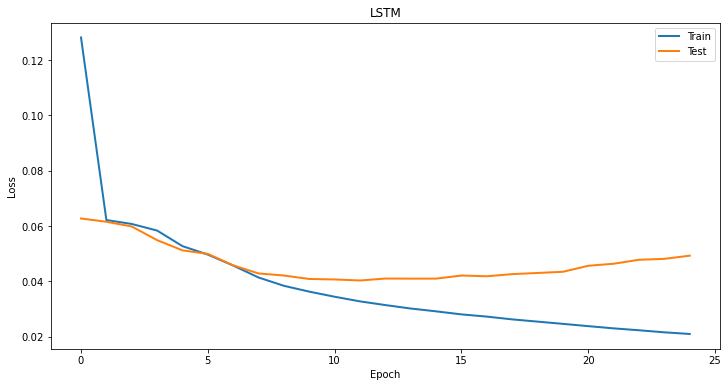

In [233]:
plot_model_loss(lstm_history, 'LSTM')

In [234]:
lstm_model.load_weights("lstm-weights.best.hdf5")
pred_prob = lstm_model.predict(x_val_seq)
pred_prob[0]

array([6.26382189e-07, 2.21354441e-07, 6.32470037e-05, 3.29909963e-05,
       5.36938785e-07, 4.23639431e-05, 5.67891357e-06, 7.21103133e-05,
       6.40375365e-05, 1.39176846e-04, 2.62707472e-04, 4.54330369e-08,
       1.14738792e-01, 5.86330891e-04, 2.56645381e-02, 1.77525465e-06,
       8.60029459e-03, 6.03383780e-03, 2.44814157e-03, 9.97443834e-08,
       5.97496864e-07, 8.01329297e-05, 1.65043332e-07, 1.74841190e-08,
       5.60970719e-08, 9.05204652e-05, 1.06182515e-05, 3.76917251e-06,
       1.35398650e-05, 4.01714260e-07, 6.19215716e-05, 8.56240869e-01,
       2.07270205e-01, 9.90157425e-02, 3.97828221e-02, 2.63999999e-02,
       4.01555896e-02, 1.34513974e-02, 9.39893126e-02, 7.11590052e-03,
       2.91582410e-07, 8.35833634e-06, 1.06494863e-05, 4.34704416e-05,
       7.02847728e-06, 5.30452053e-05, 1.19153032e-04, 1.46638183e-06,
       6.93554171e-07, 1.22850679e-05, 1.95263419e-05, 4.48576975e-05,
       8.48826787e-08, 9.42683187e-07, 7.39802708e-05, 8.34283492e-05,
      

In [235]:
import scipy

In [236]:
print(pred_prob.mean())
print(pred_prob.std())

0.012750877
0.062220536


In [237]:
#define candidate threshold values
threshold  = np.arange(0,0.5,0.01)
threshold

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

In [238]:
def classify(pred_prob, thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [239]:
from sklearn import metrics
def find_opt_threshold(y_val, threshold):
    score=[]
    #convert to 1 array
    y_true = np.array(y_val).ravel() 

    for thresh in threshold:
        
        #classes for each threshold
        y_pred_seq = classify(pred_prob, thresh) 

        #convert to 1d array
        y_pred = np.array(y_pred_seq).ravel()

        score.append(metrics.f1_score(y_true,y_pred))
    return threshold[score.index(max(score))]

In [240]:
opt_lstm = find_opt_threshold(y_val, threshold)
opt_lstm

0.24

In [241]:
y_true = np.array(y_val).ravel() 

In [242]:
y_pred_seq = classify(pred_prob, opt_lstm)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [243]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.44      0.42      0.43     13300

    accuracy                           0.99   1030800
   macro avg       0.72      0.70      0.71   1030800
weighted avg       0.99      0.99      0.99   1030800



In [244]:
def get_prediction_dataframe(y_pred_seq, y_val):
    y_pred = mlb.inverse_transform(np.array(y_pred_seq))
    y_true = mlb.inverse_transform(np.array(y_val))

    prediction_df = pd.DataFrame({'comment':x_val,'actual':y_true,'predictions':y_pred})
    return prediction_df

In [245]:
lstm_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)
lstm_prediction_df

comment  \
3126  [JJNY, โควิด, ฉุด, อสังหาฯ, อี, อีซี, สารคดี, นางงาม, การเมือง, ฝีมือ, น้ำตาล, บอล, จี้, รัฐ, กล้า, กล้า, ทำ, ป้อม, เมิน, ตอบ, คนใน, รบ, เอี่ยว, บ่อน]   
536                                                                                                                        [แม่ค้า, ออนไลน์, บ้าน, กู้, ไหม]   
473                                                                                                                                [พิม, รี่, ขอโทษ, ทักษิณ]   
349                                                                                                              [กิน, อาหารเสริม, เลือด, จระเข้, MEGA, ไหม]   
3272                                                                                                                        [หุ่น, แบบนี้, ออกกำลังกาย, หรอ]   
...                                                                                                                                                      ...   
1023                                                                                                                                      [บวชเณร, โยม, ไหม]   
3036                                                                                                                      [ทาน, งา, ดำ, ผม, กลับมา, เงา, ดำ]   
3697                                                                                                                             [อัพเดต, ราคา, เหล็ก, เรือ]   
2256                                                                                                                      [แฟน, ชอบ, ไข่ดาว, ตอน, เฟส, ไทม์]   
3510                                                                                                                                               [งบ, AWC]   

                                                             actual  \
3126                     (การเมือง, ข่าวเศรษฐกิจ, รัฐบาล, สังคมไทย)   
536              (ธนาคาร, สินเชื่อเพื่อที่อยู่อาศัย, เจ้าของธุรกิจ)   
473                                      (การเมือง, ทักษิณ ชินวัตร)   
349                                          (อาหารเสริม, โภชนาการ)   
3272                                      (ลดความอ้วน, ออกกำลังกาย)   
...                                                             ...   
1023                                               (วัด, ศาสนาพุทธ)   
3036                                                  (อาหารเสริม,)   
3697                                                        (หุ้น,)   
2256                             (ประสบการณ์ชีวิตคู่, ปัญหาความรัก)   
3510  (Value Investment, กองทุนรวม, การลงทุน, ตลาดหลักทรัพย์, หุ้น)   

                                                                predictions  
3126                                        (การเมือง, นักการเมือง, รัฐบาล)  
536                                                               (แฟชั่น,)  
473                                                 (การเมือง, นักการเมือง)  
349                                       (ความงาม, ลดความอ้วน, อาหารเสริม)  
3272                         (ลดความอ้วน, สุขภาพกาย, ออกกำลังกาย, โภชนาการ)  
...                                                                     ...  
1023                                                (วัด, ศาสนา, ศาสนาพุทธ)  
3036                                             (ความงาม, สิว, อาหารเสริม)  
3697                                                       (การลงทุน, หุ้น)  
2256  (ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์ชีวิตคู่, ปัญหาความรัก)  
3510                                                       (การลงทุน, หุ้น)  

[5154 rows x 3 columns]

In [246]:
lstm_prediction_df.to_csv("prediction-mix-lstm.csv")

In [247]:
def predict_tag(model, comment, opt=opt_lstm):  
  text=[]  
  text = [cleaner(comment)]
  text = [tokenize_word(comment)]
  seq = x_tokenizer.texts_to_sequences(text)

  pad_seq = pad_sequences(seq,  padding='post', maxlen=max_len)
  pred_prob = model.predict(pad_seq)
  classes = classify(pred_prob,opt)[0]
  classes = np.array([classes])
  classes = mlb.inverse_transform(classes)  
  return classes

In [248]:
comment = "รัฐบาลควบคุมโควิดไม่ได้เลย ทำยังไงดี"
print(predict_tag(lstm_model,comment, opt_lstm))

[('รัฐบาล', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [249]:
comment = "อยากหาร้านทำผม มีที่ไหนแนะนำบ้างครับ"
print(predict_tag(lstm_model,comment, opt_lstm))

[('ความงาม', 'ทำผม', 'ผลิตภัณฑ์ดูแลเส้นผม')]


In [250]:
comment = "การฉีดวัคซีนโควิด"
print(predict_tag(lstm_model,comment, opt_lstm))

[('กระทรวงสาธารณสุข', 'การเมือง', 'รัฐบาล', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [251]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(lstm_model,comment, opt_lstm))

[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก', 'แอบรัก')]


In [252]:
comment = "เราท่านได้ดูโครงสร้างของ อานาปานสติ ได้ที่ไหน"
print(predict_tag(lstm_model,comment, opt_lstm))

[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'มหาสติปัฏฐาน 4', 'ศาสนาพุทธ')]


In [253]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(lstm_model,comment, opt_lstm))

[('การลงทุน', 'หุ้น')]


In [254]:
comment = "ใครโสดยกมือหน่อยครับ อยากมีแฟนสักคน"
print(predict_tag(lstm_model,comment, opt_lstm))

[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก', 'ศาลาคนเศร้า')]


In [255]:
comment = "อยากลดความอ้วน แนะนำคลีนิคหน่อยครับ"
print(predict_tag(lstm_model,comment, opt_lstm))

[('ความงาม', 'ลดความอ้วน')]


In [256]:
print(predict_tag(lstm_model,comment, opt_lstm))

[('ความงาม', 'ลดความอ้วน')]


In [257]:
# GRU
# define model architecture
k.clear_session()

#sequential model
gru_model = Sequential()

#embedding layer
gru_model.add(Embedding(x_voc_size, 300, trainable = True, input_shape=(max_len,), mask_zero=True))

#lstm 
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(128))

#dense layer
gru_model.add(Dense(1024, activation='relu')) 
gru_model.add(Dropout(0.5) )

#output layer
gru_model.add(Dense(num_labels ,activation='sigmoid'))

In [258]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           1883700   
_________________________________________________________________
gru (GRU)                    (None, 10, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 2,484,988
Trainable params: 2,484,988
Non-trainable params: 0
______________________________________________

In [259]:
gru_history = train_model(gru_model, 'gru')

Epoch 1/25
162/162 [==============================] - 21s 92ms/step - loss: 0.2415 - val_loss: 0.0619

Epoch 00001: val_loss improved from inf to 0.06187, saving model to gru-weights.best.hdf5
Epoch 2/25
162/162 [==============================] - 15s 95ms/step - loss: 0.0621 - val_loss: 0.0602

Epoch 00002: val_loss improved from 0.06187 to 0.06021, saving model to gru-weights.best.hdf5
Epoch 3/25
162/162 [==============================] - 16s 96ms/step - loss: 0.0576 - val_loss: 0.0519

Epoch 00003: val_loss improved from 0.06021 to 0.05190, saving model to gru-weights.best.hdf5
Epoch 4/25
162/162 [==============================] - 15s 95ms/step - loss: 0.0507 - val_loss: 0.0479

Epoch 00004: val_loss improved from 0.05190 to 0.04785, saving model to gru-weights.best.hdf5
Epoch 5/25
162/162 [==============================] - 15s 95ms/step - loss: 0.0442 - val_loss: 0.0431

Epoch 00005: val_loss improved from 0.04785 to 0.04306, saving model to gru-weights.best.hdf5
Epoch 6/25
162/162 

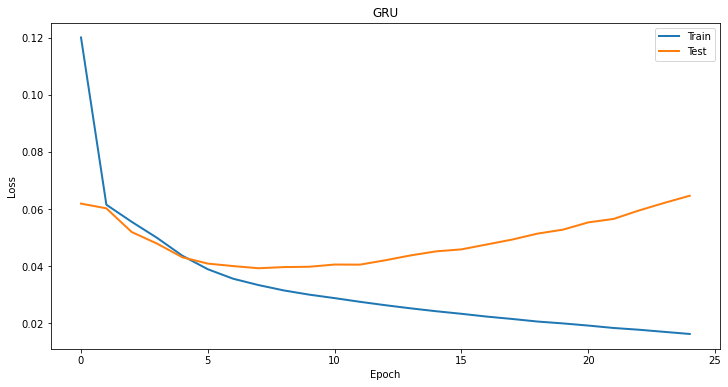

In [260]:
plot_model_loss(gru_history, 'GRU')

In [261]:
gru_model.load_weights("gru-weights.best.hdf5")
pred_prob = gru_model.predict(x_val_seq)
pred_prob[0]

array([7.32796185e-11, 2.06676343e-09, 5.96007794e-06, 1.74451795e-08,
       3.27400307e-09, 5.33593193e-05, 1.92647240e-05, 1.00078452e-07,
       5.17202170e-06, 8.18786611e-06, 1.73090502e-05, 3.07950054e-11,
       1.88413262e-03, 1.31189823e-04, 3.53991985e-04, 1.72478154e-09,
       4.35507298e-03, 3.16441983e-01, 4.88817692e-04, 6.21005158e-09,
       8.91050433e-08, 2.52523896e-05, 1.04254643e-11, 1.63051040e-12,
       2.06817983e-12, 1.37269497e-04, 8.12052986e-06, 6.42361684e-08,
       1.96042038e-05, 1.35218559e-10, 1.22565092e-04, 6.26603067e-01,
       1.83585286e-03, 2.72750854e-03, 2.00867653e-04, 6.22826815e-03,
       1.37490034e-03, 3.20649147e-03, 7.02840090e-03, 7.54997134e-03,
       1.51953272e-09, 5.70539882e-08, 8.08512635e-09, 1.53831934e-08,
       1.54864299e-09, 6.99343786e-07, 2.73560126e-08, 3.33156223e-08,
       2.77279870e-08, 2.06989679e-08, 1.93598755e-08, 3.03194865e-05,
       2.35354080e-11, 1.12957849e-07, 1.58862520e-07, 3.04726746e-06,
      

In [262]:
opt_gru = find_opt_threshold(y_val, threshold)
opt_gru

0.25

In [263]:
y_true = np.array(y_val).ravel() 

In [264]:
y_pred_seq = classify(pred_prob, opt_gru)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [265]:
print(metrics.classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.48      0.42      0.44     13300

    accuracy                           0.99   1030800
   macro avg       0.73      0.71      0.72   1030800
weighted avg       0.99      0.99      0.99   1030800



In [266]:
gru_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)

In [267]:
gru_prediction_df.to_csv("prediction-mix-gru.csv")

In [268]:
comment = "อยากหาร้านทำผม มีที่ไหนแนะนำบ้างครับ"
print(predict_tag(gru_model,comment, opt_gru))

[('ทำผม', 'ผลิตภัณฑ์ดูแลเส้นผม')]


In [269]:
comment = "การฉีดวัคซีนโควิด"
print(predict_tag(gru_model,comment, opt_gru))

[('กระทรวงสาธารณสุข', 'การเมือง', 'รัฐบาล', 'วัคซีน (Vaccine)', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [270]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(gru_model,comment, opt_gru))

[('ความรักวัยทำงาน', 'ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ประสบการณ์ชีวิตคู่', 'ปัญหาความรัก')]


In [271]:
comment = "เราท่านได้ดูโครงสร้างของ อานาปานสติ ได้ที่ไหน"
print(predict_tag(gru_model,comment, opt_gru))

[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'มหาสติปัฏฐาน 4', 'ศาสนาพุทธ')]


In [272]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(gru_model,comment, opt_gru))

[('การลงทุน', 'ตลาดหลักทรัพย์', 'หุ้น')]


In [273]:
comment = "ใครโสดยกมือหน่อยครับ อยากมีแฟนสักคน"
print(predict_tag(gru_model,comment, opt_gru))

[('ความรักวัยทำงาน', 'ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก')]


In [274]:
comment = "อยากลดความอ้วน แนะนำคลีนิคหน่อยครับ"
print(predict_tag(gru_model,comment, opt_gru))

[('ลดความอ้วน', 'สิว')]


In [275]:
# Simple RNN
# define model architecture
k.clear_session()

#sequential model
rnn_model = Sequential()

#embedding layer
rnn_model.add(Embedding(x_voc_size, 300, trainable = True, input_shape=(max_len,), mask_zero=True))

#lstm 
rnn_model.add(SimpleRNN(128, return_sequences=True))
rnn_model.add(SimpleRNN(128))

#dense layer
rnn_model.add(Dense(1024, activation='relu')) 
rnn_model.add(Dropout(0.5) )

#output layer
rnn_model.add(Dense(num_labels ,activation='sigmoid'))

In [276]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           1883700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 128)           54912     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 2,308,604
Trainable params: 2,308,604
Non-trainable params: 0
______________________________________________

In [277]:
rnn_history = train_model(rnn_model, 'rnn')

Epoch 1/25
162/162 [==============================] - 11s 60ms/step - loss: 0.1866 - val_loss: 0.0620

Epoch 00001: val_loss improved from inf to 0.06197, saving model to rnn-weights.best.hdf5
Epoch 2/25
162/162 [==============================] - 9s 58ms/step - loss: 0.0625 - val_loss: 0.0564

Epoch 00002: val_loss improved from 0.06197 to 0.05643, saving model to rnn-weights.best.hdf5
Epoch 3/25
162/162 [==============================] - 9s 58ms/step - loss: 0.0554 - val_loss: 0.0523

Epoch 00003: val_loss improved from 0.05643 to 0.05229, saving model to rnn-weights.best.hdf5
Epoch 4/25
162/162 [==============================] - 10s 59ms/step - loss: 0.0508 - val_loss: 0.0474

Epoch 00004: val_loss improved from 0.05229 to 0.04738, saving model to rnn-weights.best.hdf5
Epoch 5/25
162/162 [==============================] - 9s 58ms/step - loss: 0.0434 - val_loss: 0.0425

Epoch 00005: val_loss improved from 0.04738 to 0.04249, saving model to rnn-weights.best.hdf5
Epoch 6/25
162/162 [==

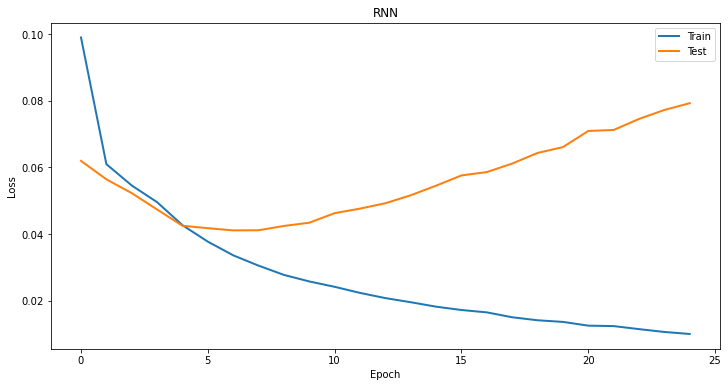

In [278]:
plot_model_loss(rnn_history, 'RNN')

In [279]:
rnn_model.load_weights("rnn-weights.best.hdf5")
pred_prob = rnn_model.predict(x_val_seq)
pred_prob[0]

array([7.78500961e-08, 2.96010683e-07, 5.59357977e-06, 1.02183403e-05,
       3.74604241e-07, 7.70116458e-07, 2.05699371e-06, 1.11972236e-06,
       9.90671906e-05, 9.73960960e-06, 1.61333319e-05, 2.33613342e-08,
       4.40501571e-02, 4.86761819e-05, 2.66063213e-02, 6.52181916e-06,
       7.39902258e-04, 1.58944726e-03, 7.47176746e-05, 9.81750600e-06,
       4.84988959e-07, 2.06359873e-05, 4.23302389e-08, 4.51621780e-08,
       1.00613974e-07, 1.03361790e-05, 3.21659195e-06, 1.94937707e-06,
       2.48942069e-06, 7.31573664e-07, 1.59431365e-05, 9.87026572e-01,
       1.40526295e-02, 2.03014314e-02, 3.62455845e-04, 1.05535984e-03,
       6.31558895e-03, 2.63947248e-03, 1.01885855e-01, 5.51034464e-05,
       1.81405940e-05, 5.43129715e-07, 3.11136802e-07, 4.86436738e-06,
       4.91073570e-06, 1.39728381e-05, 1.57666836e-05, 3.52305705e-07,
       7.40511382e-07, 1.51572640e-05, 4.28140163e-04, 4.02998376e-06,
       1.28009361e-07, 9.18780131e-07, 8.41087058e-06, 2.03251147e-06,
      

In [280]:
y_true = np.array(y_val).ravel() 

In [281]:
rnn_opt = find_opt_threshold(y_val, threshold)
rnn_opt

0.2

In [282]:
y_pred_seq = classify(pred_prob, rnn_opt)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [283]:
print(metrics.classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.43      0.42      0.42     13300

    accuracy                           0.99   1030800
   macro avg       0.71      0.71      0.71   1030800
weighted avg       0.99      0.99      0.99   1030800



In [284]:
rnn_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)

In [285]:
rnn_prediction_df.to_csv("prediction-mix-rnn.csv")

In [286]:
comment = "รัฐบาลควบคุมโควิดไม่ได้เลย ทำยังไงดี"
print(predict_tag(rnn_model,comment, rnn_opt))

[('การเมือง', 'รัฐบาล', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [287]:
comment = "อยากหาร้านทำผม มีที่ไหนแนะนำบ้างครับ"
print(predict_tag(rnn_model,comment, rnn_opt))

[('ทำผม', 'ผลิตภัณฑ์ดูแลเส้นผม')]


In [288]:
comment = "การฉีดวัคซีนโควิด"
print(predict_tag(rnn_model,comment, rnn_opt))

[('กระทรวงสาธารณสุข', 'การเมือง', 'รัฐบาล', 'วัคซีน (Vaccine)', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [289]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(rnn_model,comment, rnn_opt))

[('ความรักวัยทำงาน', 'ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก', 'แอบรัก')]


In [290]:
comment = "เราท่านได้ดูโครงสร้างของ อานาปานสติ ได้ที่ไหน"
print(predict_tag(rnn_model,comment, rnn_opt))

[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'มหาสติปัฏฐาน 4', 'ศาสนา', 'ศาสนาพุทธ')]


In [291]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(rnn_model,comment, rnn_opt))

[('หุ้น',)]


In [292]:
comment = "อยากลดความอ้วน แนะนำคลีนิคหน่อยครับ"
print(predict_tag(rnn_model,comment, rnn_opt))

[('ลดความอ้วน', 'ศัลยกรรมความงาม', 'ออกกำลังกาย')]
